In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
from docs.untitled import fred_api_key
import pandas as pd
import fredapi as fr
from sklearn.preprocessing import MinMaxScaler
import numpy as np


fred = fr.Fred(fred_api_key)




device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

"""Interest Rates(Fed Funds Rate) """

ffr = fred.get_series("FEDFUNDS")
ffr.name = "Fed Funds Rate"

data = pd.DataFrame(ffr).dropna()

data = data.reset_index()
data['Date'] = data['index']
data.drop("index",axis=1,inplace=True)
data.head(10)

cuda:0


,Fed Funds Rate,Date
0,0.80,1954-07-01
1,1.22,1954-08-01
2,1.07,1954-09-01
3,0.85,1954-10-01
4,0.83,1954-11-01
5,1.28,1954-12-01
6,1.39,1955-01-01
7,1.29,1955-02-01
8,1.35,1955-03-01
9,1.43,1955-04-01


In [3]:

training = data.iloc[:,0:1].values



train_split = int(len(training) * .70)

train_data = training[:train_split]
test_data = training[train_split:]
train_data.shape
test_data.shape

scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

def slider(df, seq_length):
    X, y = [], []
    for i in range(len(df) - seq_length):
        X_ = df[i:(i + seq_length)]
        y_ = df[i + seq_length]
        X.append(X_)
        y.append(y_)
    return np.array(X), np.array(y)

seq_length = 1
X_train, y_train = slider(train_data, seq_length)
X_test,y_test = slider(test_data,seq_length)


X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()


X_train.shape
y_train.shape


class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers,output_size):
        super(LSTM,self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
        
        self.fc = nn.Linear(hidden_size,output_size)
        
    def forward(self,X):
        h0 = torch.zeros(self.num_layers,X.size(0),self.hidden_size)
        c0 = torch.zeros(self.num_layers,X.size(0),self.hidden_size)
        out,_ = self.lstm(X,(h0,c0))
        out = self.fc(out[:,-1,:])
        return out



model = LSTM(input_size=1,hidden_size=512,num_layers=1,output_size=1)
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
loss_fn = nn.MSELoss(reduction="sum")
epochs = 200

for epoch in range(epochs):
    y_pred = model(X_train)
    loss = loss_fn(y_pred.float(),y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 1 == 0:
        print(f'Epoch {epochs} train loss: {loss.item()}')

Epoch 200 train loss: 52.66672134399414
Epoch 200 train loss: 26.976898193359375
Epoch 200 train loss: 16.945667266845703
Epoch 200 train loss: 24.69669532775879
Epoch 200 train loss: 22.95846176147461
Epoch 200 train loss: 16.23862075805664
Epoch 200 train loss: 14.217619895935059
Epoch 200 train loss: 16.513742446899414
Epoch 200 train loss: 17.060836791992188
Epoch 200 train loss: 14.160689353942871
Epoch 200 train loss: 10.623632431030273
Epoch 200 train loss: 9.273554801940918
Epoch 200 train loss: 10.067790985107422
Epoch 200 train loss: 10.166719436645508
Epoch 200 train loss: 8.105835914611816
Epoch 200 train loss: 5.533897399902344
Epoch 200 train loss: 4.42207670211792
Epoch 200 train loss: 4.679827690124512
Epoch 200 train loss: 4.559534072875977
Epoch 200 train loss: 3.1174421310424805
Epoch 200 train loss: 1.473402500152588
Epoch 200 train loss: 1.1901899576187134
Epoch 200 train loss: 1.8788809776306152
Epoch 200 train loss: 1.7463343143463135
Epoch 200 train loss: 0.8945

In [4]:
model.eval()
with torch.no_grad():
    for epoch in range(epochs):
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)

print(f'train loss: {loss.item()} test loss: {test_loss.item()}')
    


train loss: 0.5473490953445435 test loss: 0.022484544664621353


In [5]:

with torch.no_grad():
    pred = model(X_test)
    pred_np = pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)



test_dates = data.iloc[train_split + seq_length:]['Date'].reset_index(drop=True)


comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Interest Rate": actual_rescaled.flatten(),
    "Predicted Interest Rate": pred_rescaled.flatten()
})


print(comparison_df.tail(20))

          Date  Actual Interest Rate  Predicted Interest Rate
234 2023-09-01                  5.33                 5.349109
235 2023-10-01                  5.33                 5.349109
236 2023-11-01                  5.33                 5.349109
237 2023-12-01                  5.33                 5.349109
238 2024-01-01                  5.33                 5.349109
239 2024-02-01                  5.33                 5.349109
240 2024-03-01                  5.33                 5.349109
241 2024-04-01                  5.33                 5.349109
242 2024-05-01                  5.33                 5.349109
243 2024-06-01                  5.33                 5.349109
244 2024-07-01                  5.33                 5.349109
245 2024-08-01                  5.33                 5.349109
246 2024-09-01                  5.13                 5.349109
247 2024-10-01                  4.83                 5.150422
248 2024-11-01                  4.64                 4.852217
249 2024

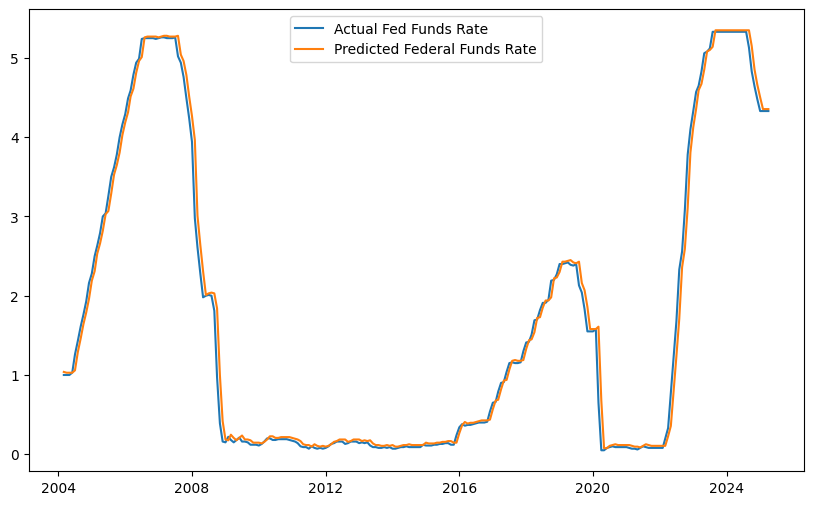

In [6]:
plt.figure(figsize=(10,6))
plt.plot(comparison_df['Date'],comparison_df["Actual Interest Rate"],label="Actual Fed Funds Rate")
plt.plot(comparison_df['Date'],comparison_df['Predicted Interest Rate'],label="Predicted Federal Funds Rate")
plt.legend()
plt.savefig("images/predicted_actual_interestrates.png")
plt.show()
